# Implementation of Multilayer Perceptrons
:label:`sec_mlp-implementation`

Multilayer perceptrons (MLPs) are not much more complex to implement than simple linear models. The key conceptual
difference is that we now concatenate multiple layers.


In [17]:
import tensorflow as tf
from d2l import tensorflow as d2l
import random
import matplotlib.pyplot as plt

## Implementation from Scratch

Let's begin again by implementing such a network from scratch.

### Initializing Model Parameters

Lembre-se de que o Fashion-MNIST contém 10 classes e que cada imagem consiste em uma grade de valores de pixel em escala de cinza de $28 \times 28 = 784$. Como antes, vamos ignorar a estrutura espacial entre os pixels por enquanto, de modo que podemos pensar nisso como um conjunto de dados de classificação com 784 características de entrada e 10 classes. Para começar, vamos [implementar um MLP com uma camada oculta e 256 unidades ocultas.] Tanto o número de camadas quanto sua largura são ajustáveis (considerados hiperparâmetros). Tipicamente, escolhemos larguras de camada que sejam divisíveis por potências maiores de 2. Isso é eficiente computacionalmente devido à forma como a memória é alocada e endereçada no hardware.

Novamente, representaremos nossos parâmetros com vários tensores. Observe que para cada camada, devemos controlar uma matriz de pesos e um vetor de viés. Como sempre, alocamos memória para os gradientes da perda em relação a esses parâmetros.








No código abaixo, usamos tf.Variable para definir o parâmetro do modelo.


In [2]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = tf.Variable(
            tf.random.normal((num_inputs, num_hiddens)) * sigma)
        self.b1 = tf.Variable(tf.zeros(num_hiddens))
        self.W2 = tf.Variable(
            tf.random.normal((num_hiddens, num_outputs)) * sigma)
        self.b2 = tf.Variable(tf.zeros(num_outputs))

### Model

Para garantir que entendemos como tudo funciona, vamos implementar a ativação ReLU nós mesmos, em vez de invocar diretamente a função embutida relu.


In [3]:
def relu(X):
    return tf.math.maximum(X, 0)

Since we are disregarding spatial structure,
we `reshape` each two-dimensional image into
a flat vector of length  `num_inputs`.
Finally, we (**implement our model**)
with just a few lines of code. Since we use the framework built-in autograd this is all that it takes.

####################################################################


Como estamos desconsiderando a estrutura espacial, `redimensionamos` cada imagem bidimensional em um vetor plano de comprimento `num_inputs`. Finalmente, (**implementamos nosso**) modelo com apenas algumas linhas de código. Como usamos o autograd integrado ao framework, é tudo o que é necessário.


In [4]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = tf.reshape(X, (-1, self.num_inputs))
    H = relu(tf.matmul(X, self.W1) + self.b1)
    return tf.matmul(H, self.W2) + self.b2

### Training

Fortunately, [**the training loop for MLPs
is exactly the same as for softmax regression.**] We define the model, data, and trainer, then finally invoke the `fit` method on model and data.

####################################################################

Felizmente, o ciclo de treinamento para MLPs é exatamente o mesmo que para regressão softmax. Definimos o modelo, os dados e o treinador e, por fim, invocamos o método fit no modelo e nos dados.

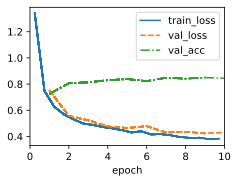

In [5]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)



## Concise Implementation

As you might expect, by relying on the high-level APIs, we can implement MLPs even more concisely.

####################################################################

Como você pode esperar, ao confiar nas APIs de alto nível, podemos implementar MLPs de maneira ainda mais concisa.


### Model

Compared with our concise implementation
of softmax regression implementation
(:numref:`sec_softmax_concise`),
the only difference is that we add
*two* fully connected layers where we previously added only *one*.
The first is [**the hidden layer**],
the second is the output layer.

####################################################################
### Modelo

Comparada com a nossa implementação concisa de regressão softmax (ver secção 3.6), a única diferença é que adicionamos duas camadas totalmente conectadas, onde antes adicionamos apenas uma. A primeira é a camada oculta, a segunda é a camada de saída.

In [6]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_outputs)])

Previously, we defined `forward` methods for models to transform input using the model parameters.
These operations are essentially a pipeline:
you take an input and
apply a transformation (e.g.,
matrix multiplication with weights followed by bias addition),
then repetitively use the output of the current transformation as
input to the next transformation.
However, you may have noticed that 
no `forward` method is defined here.
In fact, `MLP` inherits the `forward` method from the `Module` class (:numref:`subsec_oo-design-models`) to 
simply invoke `self.net(X)` (`X` is input),
which is now defined as a sequence of transformations
via the `Sequential` class.
The `Sequential` class abstracts the forward process
enabling us to focus on the transformations.
We will further discuss how the `Sequential` class works in :numref:`subsec_model-construction-sequential`.


### Training

[**The training loop**] is exactly the same
as when we implemented softmax regression.
This modularity enables us to separate
matters concerning the model architecture
from orthogonal considerations.

####################################################################

Anteriormente, definimos métodos forward para os modelos transformarem a entrada usando os parâmetros do modelo. Essas operações são essencialmente um pipeline: você pega uma entrada e aplica uma transformação (por exemplo, multiplicação de matriz com pesos seguida de adição de viés), e então usa repetidamente a saída da transformação atual como entrada para a próxima transformação. No entanto, você pode ter percebido que nenhum método forward é definido aqui. Na verdade, MLP herda o método forward da classe Module (ver secção 6.5) para simplesmente invocar self.net(X) (X é a entrada), que agora é definida como uma sequência de transformações por meio da classe Sequential. A classe Sequential abstrai o processo de avanço, permitindo-nos focar nas transformações. Discutiremos mais sobre como a classe Sequential funciona na secção 6.8.

### Treinamento
**O ciclo de treinamento** é exatamente o mesmo que quando implementamos a regressão softmax. Essa modularidade nos permite separar questões relacionadas à arquitetura do modelo de considerações ortogonais.

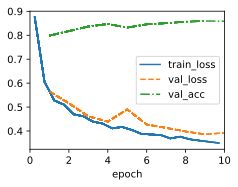

In [7]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

In [13]:
X,y=next(iter(data.val_dataloader()))
preds=tf.argmax(model(X),axis=1)
preds.shape

TensorShape([256])

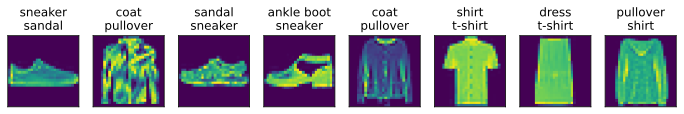

In [12]:
wrong=tf.cast(preds,y.dtype)!=y
X,y,preds=X[wrong],y[wrong],preds[wrong]
labels=[a+'\n'+b for a,b in zip(data.text_labels(y),data.text_labels(preds))]
data.visualize([X,y],labels=labels)

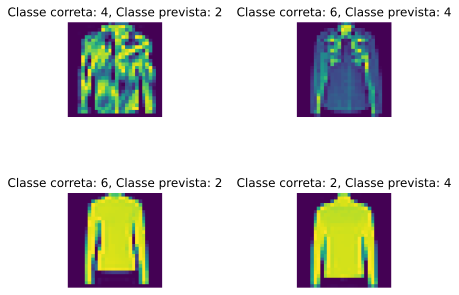

In [32]:
import random
import matplotlib.pyplot as plt

misclassified_examples = []

for i in range(len(X)):
    if tf.cast(preds[i], y.dtype) != y[i]:
        misclassified_examples.append((X[i], y[i], preds[i]))

# Selecionar aleatoriamente 4 exemplos mal classificados
random_selection = random.sample(misclassified_examples, 4)

# Visualizar as 4 imagens selecionadas aleatoriamente com espaçamento maior entre as subplots
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.8, wspace=0.8)  # Ajuste o espaçamento conforme necessário

for idx, example in enumerate(random_selection):
    X_example, y_example, pred_example = example
    ax = axs[idx // 2, idx % 2]
    ax.imshow(X_example)  # Certifique-se de que X_example seja uma imagem
    ax.set_title(f'Classe correta: {y_example}, Classe prevista: {pred_example}')
    ax.axis('off')

plt.show()


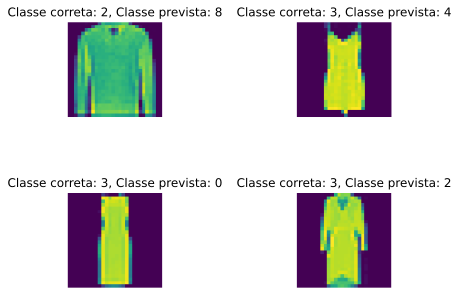

In [42]:
import random
import matplotlib.pyplot as plt

# 0 Cria uma lista onde vamos armazenar todos os exemplos mal-classificados
all_misclassified_examples = []

# 1 Vamos percorrer todos os minibatches, e encontrar os erros na classificação
for X, y in data.val_dataloader():
    misclassified_examples = []

    for i in range(len(X)):
        if tf.cast(preds[i], y.dtype) != y[i]:
            misclassified_examples.append((X[i], y[i], preds[i]))

    # 2 Encontrado os erros vamos armazená-los em uma lista
    all_misclassified_examples.extend(misclassified_examples)

# 3 Vamos mostrar aleatoriamente 4 elementos aleatórios dessa lista, depois de percorrer todos os erros
random_selection = random.sample(all_misclassified_examples, 4)

# Visualizar os 4 exemplos selecionados aleatoriamente no final
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.8, wspace=0.8)  # Ajustar o espaçamento conforme necessário

for idx, example in enumerate(random_selection):
    X_example, y_example, pred_example = example
    ax = axs[idx // 2, idx % 2]
    ax.imshow(X_example)  # Certifique-se de que X_example seja uma imagem
    ax.set_title(f'Classe correta: {y_example}, Classe prevista: {pred_example}')
    ax.axis('off')

plt.show()


## Summary

Now that we have more practice in designing deep networks, the step from a single to multiple layers of deep networks does not pose such a significant challenge any longer. In particular, we can reuse the training algorithm and data loader. Note, though, that implementing MLPs from scratch is nonetheless messy: naming and keeping track of the model parameters makes it difficult to extend models. For instance, imagine wanting to insert another layer between layers 42 and 43. This might now be layer 42b, unless we are willing to perform sequential renaming. Moreover, if we implement the network from scratch, it is much more difficult for the framework to perform meaningful performance optimizations.

Nonetheless, you have now reached the state of the art of the late 1980s when fully connected deep networks were the method of choice for neural network modeling. Our next conceptual step will be to consider images. Before we do so, we need to review a number of statistical basics and details on how to compute models efficiently.


## Exercises

1. Change the number of hidden units `num_hiddens` and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?
1. Try adding a hidden layer to see how it affects the results.
1. Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?
1. How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?
1. Let's optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.
    1. What is the best result you can get by optimizing over all of them?
    1. Why it is much more challenging to deal with multiple hyperparameters?
    1. Describe an efficient strategy for optimizing over multiple parameters jointly.
1. Compare the speed of the framework and the from-scratch implementation for a challenging problem. How does it change with the complexity of the network?
1. Measure the speed of tensor--matrix multiplications for well-aligned and misaligned matrices. For instance, test for matrices with dimension 1024, 1025, 1026, 1028, and 1032.
    1. How does this change between GPUs and CPUs?
    1. Determine the memory bus width of your CPU and GPU.
1. Try out different activation functions. Which one works best?
1. Is there a difference between weight initializations of the network? Does it matter?


[Discussions](https://discuss.d2l.ai/t/227)
